## We want to fine the best margin to most separate different classes. 
## i.e. find the closest points to the hyperplane and maximize their distances W to the hyperplane

we want min (1/2*||W||^2) wrt w and b, such that yi*(w*xi + b) -1 >=0, i = 1,2,...,N
By solving w and b, we will get a linear-separable support vector machine, and the hypterplane is 
w*x + b = 0
the decsion function is f(x) = sign(w*x + b)

We transform this problem into a Lagrange Duality problem to solve
min 1/2*sum_of_i(sum_of_j(ai*aj*yi*yj*(xi*xj))) - sum_of_i(ai)
s.t. sum_of_i(ai*yi) = 0
ai >= 0

Use SMO algorithm to solve a, then calculate b
f(x) = sign(sum_of_i(ai*yi*K(xi*xj) + b))

In [126]:
from numpy import * 

def loadDataSet(filename): #读取数据
    dataMat=[]
    labelMat=[]
    fr=open(filename)
    for line in fr.readlines():
        lineArr=line.strip().split(',')
        dataMat.append([float(lineArr[1]),float(lineArr[2])])
        labelMat.append(float(lineArr[3]))
    return dataMat,labelMat #返回数据特征和数据类别

def selectJrand(i,m): #在0-m中随机选择一个不是i的整数
    j=i
    while (j==i):
        j=int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):  #保证a在L和H范围内（L <= a <= H）
    if aj>H:
        aj=H
    if L>aj:
        aj=L
    return aj

def kernelTrans(X, A, kTup): #核函数，输入参数,X:支持向量的特征树；A：某一行特征数据；kTup：('lin',k1)核函数的类型和参数
    m,n = shape(X)
    K = mat(zeros((m,1)))
    if kTup[0]=='lin': #线性函数
        K = X * A.T
    elif kTup[0]=='rbf': # 径向基函数(radial bias function)
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = exp(K/(-1*kTup[1]**2)) #返回生成的结果
    else:
        raise NameError('Houston We Have a Problem -- That Kernel is not recognized')
    return K


#定义类，方便存储数据
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  # 存储各类参数
        self.X = dataMatIn  #数据特征
        self.labelMat = classLabels #数据类别
        self.C = C #软间隔参数C，参数越大，非线性拟合能力越强
        self.tol = toler #停止阀值
        self.m = shape(dataMatIn)[0] #数据行数
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0 #初始设为0
        self.eCache = mat(zeros((self.m,2))) #缓存
        self.K = mat(zeros((self.m,self.m))) #核函数的计算结果
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)


def calcEk(oS, k): #计算Ek（参考《统计学习方法》p127公式7.105）
    fXk = float(multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

#随机选取aj，并返回其E值
def selectJ(i, oS, Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1,Ei]
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]  #返回矩阵中的非零位置的行数
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:
            if k == i:
                continue
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE): #返回步长最大的aj
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej


def updateEk(oS, k): #更新os数据
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]

#首先检验ai是否满足KKT条件，如果不满足，随机选择aj进行优化，更新ai,aj,b值
def innerL(i, oS): #输入参数i和所有参数数据
    Ei = calcEk(oS, i) #计算E值
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)): #检验这行数据是否符合KKT条件 参考《统计学习方法》p128公式7.111-113
        j,Ej = selectJ(i, oS, Ei) #随机选取aj，并返回其E值
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if (oS.labelMat[i] != oS.labelMat[j]): #以下代码的公式参考《统计学习方法》p126
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H:
            print("L==H")
            return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] #参考《统计学习方法》p127公式7.107
        if eta >= 0:
            print("eta>=0")
            return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta #参考《统计学习方法》p127公式7.106
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L) #参考《统计学习方法》p127公式7.108
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < oS.tol): #alpha变化大小阀值（自己设定）
            print("j not moving enough")
            return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#参考《统计学习方法》p127公式7.109
        updateEk(oS, i) #更新数据
        #以下求解b的过程，参考《统计学习方法》p129公式7.114-7.116
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        if (0 < oS.alphas[i]<oS.C):
            oS.b = b1
        elif (0 < oS.alphas[j]<oS.C):
            oS.b = b2
        else:
            oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0


#SMO函数，用于快速求解出alpha
def smoP(dataMatIn, classLabels, C, toler, maxIter,kTup=('lin', 0)): #输入参数：数据特征，数据类别，参数C，阀值toler，最大迭代次数，核函数（默认线性核）
    oS = optStruct(mat(dataMatIn),mat(classLabels).transpose(),C,toler, kTup)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m): #遍历所有数据
                alphaPairsChanged += innerL(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)) #显示第多少次迭代，那行特征数据使alpha发生了改变，这次改变了多少次alpha
            iter += 1
        else:
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs: #遍历非边界的数据
                alphaPairsChanged += innerL(i,oS)
                print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:
            entireSet = False
        elif (alphaPairsChanged == 0):
            entireSet = True
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas

def testRbf(data_train,data_test):
    dataArr,labelArr = loadDataSet(data_train) #读取训练数据
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', 1.3)) #通过SMO算法得到b和alpha
    datMat=mat(dataArr)
    labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas)[0]  #选取不为0数据的行数（也就是支持向量）
    sVs=datMat[svInd] #支持向量的特征数据
    labelSV = labelMat[svInd] #支持向量的类别（1或-1）
    print("there are %d Support Vectors" % shape(sVs)[0]) #打印出共有多少的支持向量
    m,n = shape(datMat) #训练数据的行列数
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', 1.3)) #将支持向量转化为核函数
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b  #这一行的预测结果（代码来源于《统计学习方法》p133里面最后用于预测的公式）注意最后确定的分离平面只有那些支持向量决定。
        if sign(predict)!=sign(labelArr[i]): #sign函数 -1 if x < 0, 0 if x==0, 1 if x > 0
            errorCount += 1
    print("the training error rate is: %f" % (float(errorCount)/m)) #打印出错误率
    dataArr_test,labelArr_test = loadDataSet(data_test) #读取测试数据
    errorCount_test = 0
    datMat_test=mat(dataArr_test)
    labelMat = mat(labelArr_test).transpose()
    m,n = shape(datMat_test)
    for i in range(m): #在测试数据上检验错误率
        kernelEval = kernelTrans(sVs,datMat_test[i,:],('rbf', 1.3))
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr_test[i]):
            errorCount_test += 1
    print("the test error rate is: %f" % (float(errorCount_test)/m))

#主程序
def main():
    filename_traindata='/Users/WeiYu/Desktop/train.txt'
    filename_testdata='/Users/WeiYu/Desktop/test.txt'
    testRbf(filename_traindata,filename_testdata)

if __name__=='__main__':
    main()

L==H
fullSet, iter: 0 i:0, pairs changed 0
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
fullSet, iter: 0 i:3, pairs changed 3
fullSet, iter: 0 i:4, pairs changed 3
fullSet, iter: 0 i:5, pairs changed 4
fullSet, iter: 0 i:6, pairs changed 4
fullSet, iter: 0 i:7, pairs changed 5
fullSet, iter: 0 i:8, pairs changed 5
fullSet, iter: 0 i:9, pairs changed 5
fullSet, iter: 0 i:10, pairs changed 6
fullSet, iter: 0 i:11, pairs changed 7
fullSet, iter: 0 i:12, pairs changed 7
fullSet, iter: 0 i:13, pairs changed 8
fullSet, iter: 0 i:14, pairs changed 9
fullSet, iter: 0 i:15, pairs changed 10
fullSet, iter: 0 i:16, pairs changed 11
fullSet, iter: 0 i:17, pairs changed 12
fullSet, iter: 0 i:18, pairs changed 13
fullSet, iter: 0 i:19, pairs changed 14
fullSet, iter: 0 i:20, pairs changed 14
fullSet, iter: 0 i:21, pairs changed 15
j not moving enough
fullSet, iter: 0 i:22, pairs changed 15
j not moving enough
fullSet, iter: 0 i:23, pairs changed 15
fullSet, iter: 0 i:2

In [128]:
dataArr,labelArr = loadDataSet('/Users/WeiYu/Desktop/train.txt') #读取训练数据

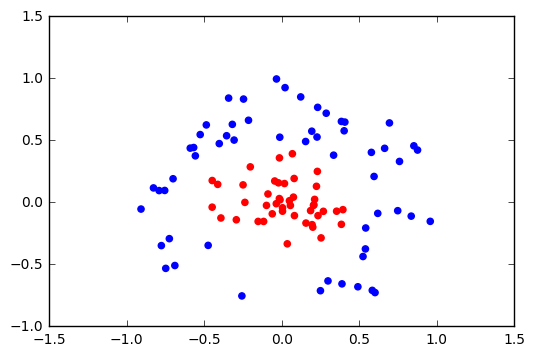

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = {1:'r',-1:'b'}
plt.scatter(np.array(dataArr)[:,0],np.array(dataArr)[:,1],marker='o',color = [colors[i] for i in labelArr])
#plt.axis([-5,10,-12,-1])
plt.show()